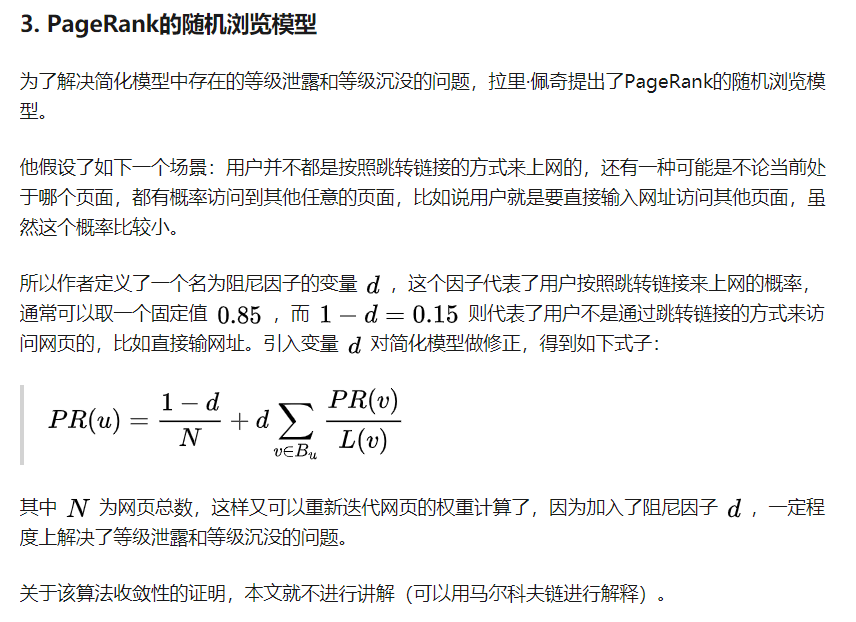

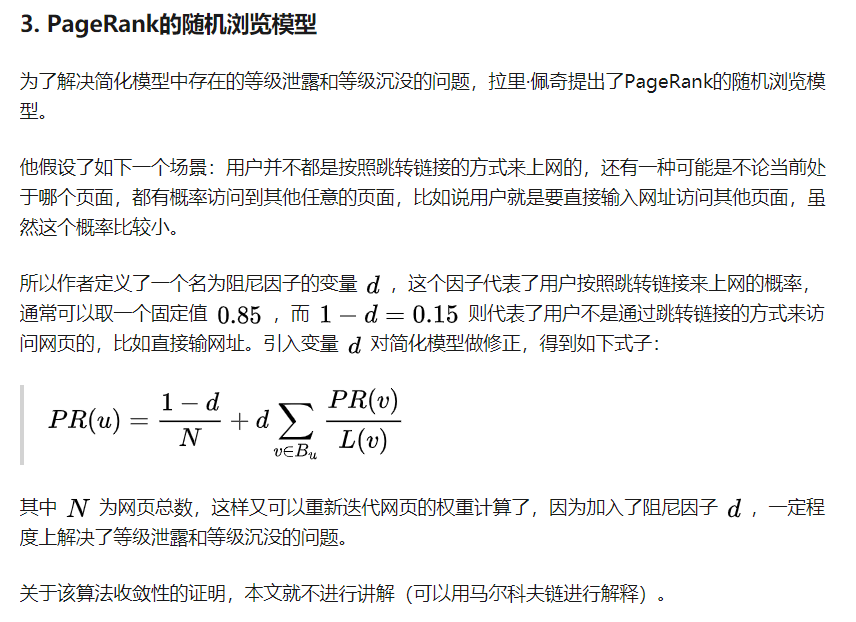

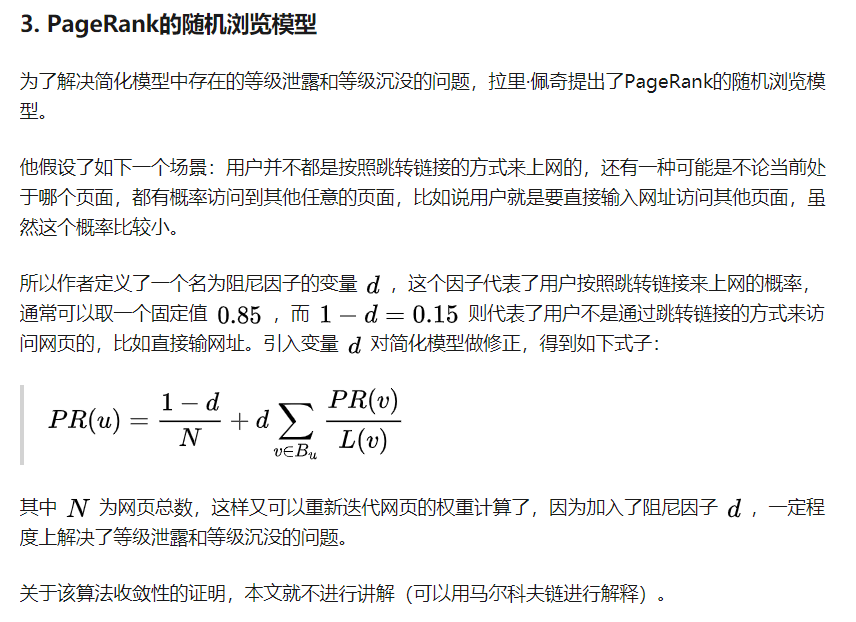

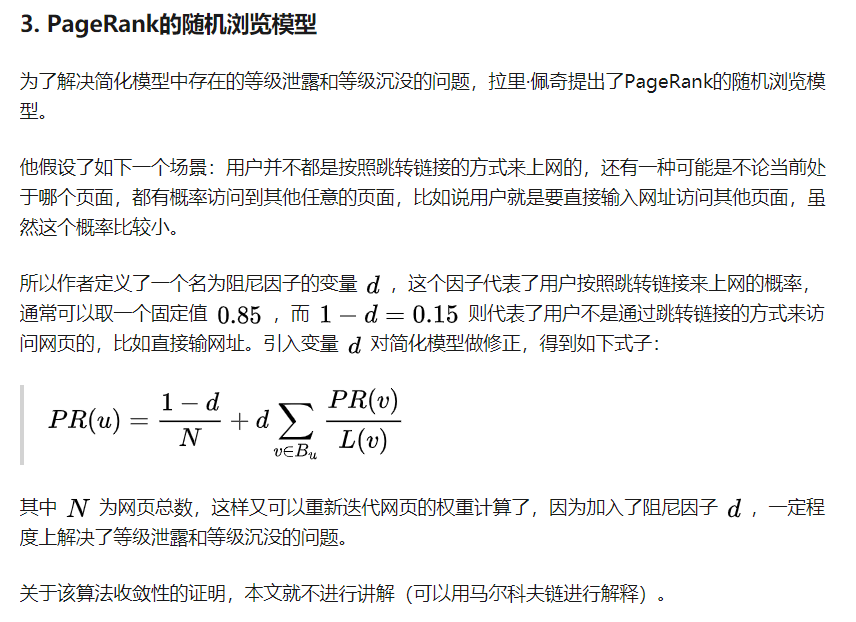

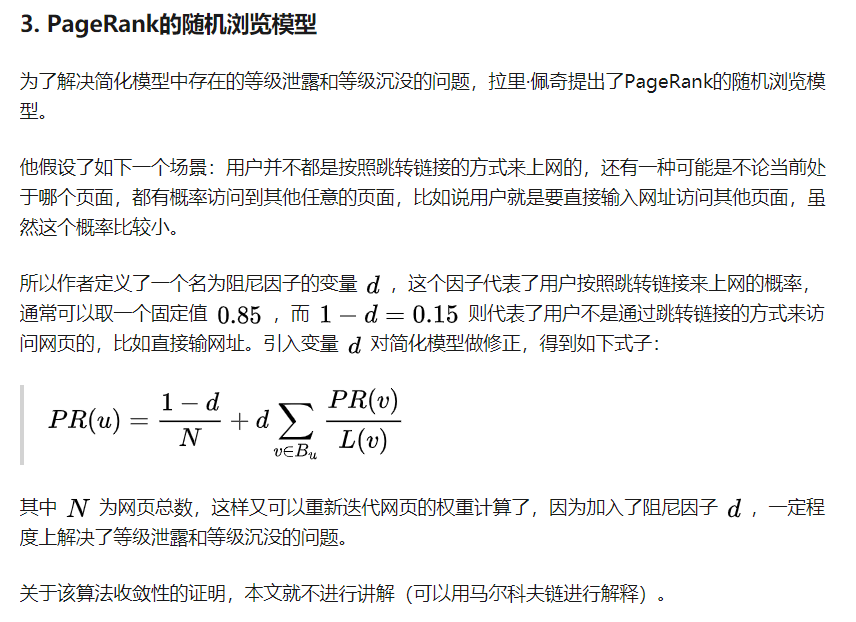

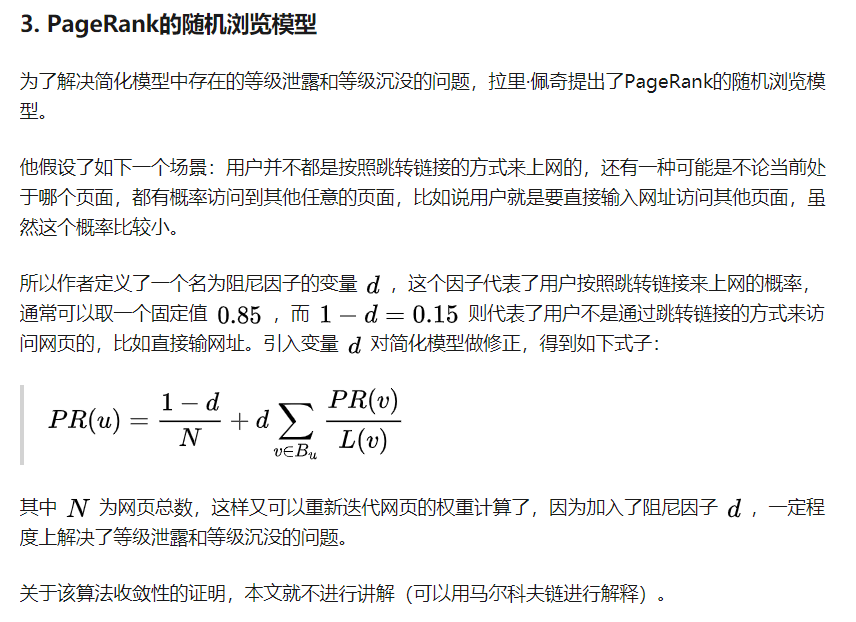

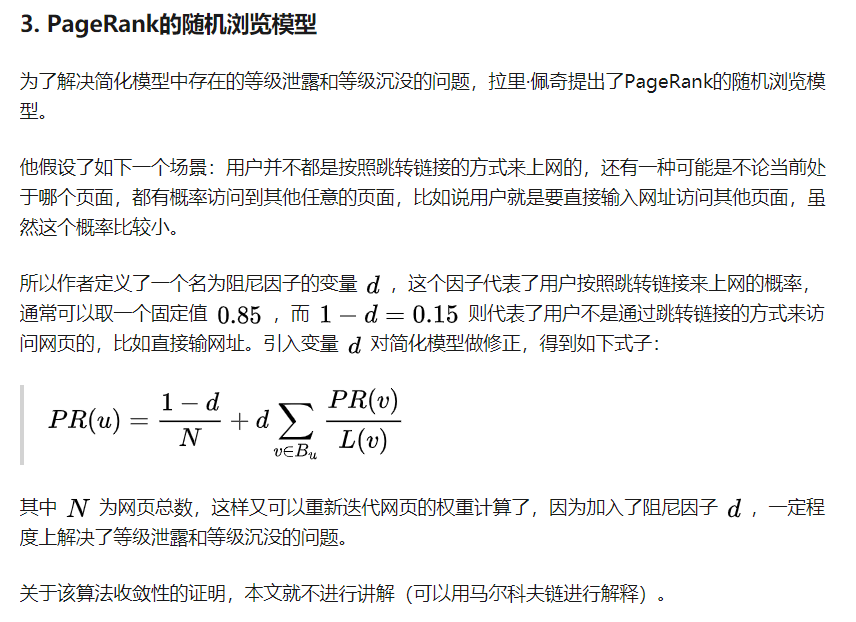

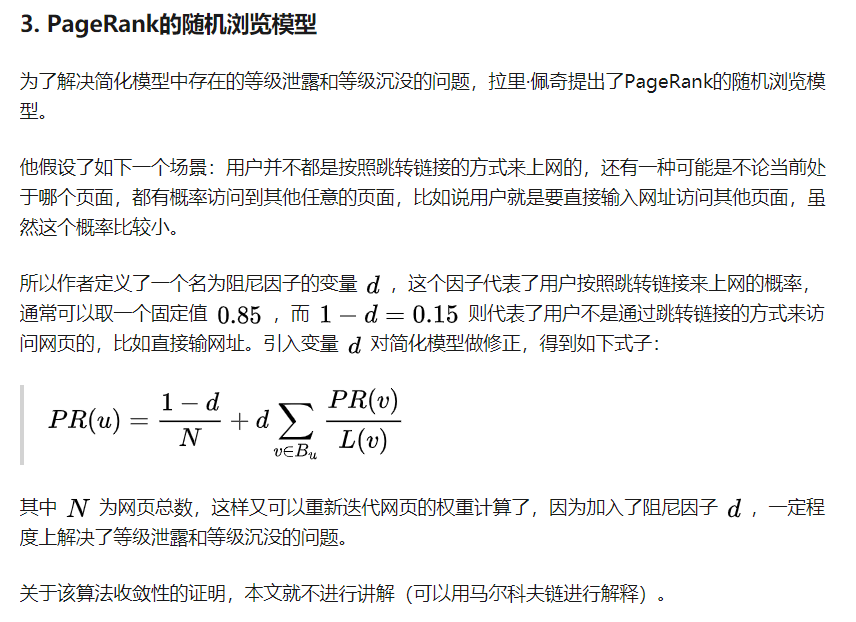


In [ ]:
   /**
     * 构建顶点数据
     */
    val vertexRDD = followData.flatMap { arr =>
      arr.map(uid => (uid, 1.0))
    }.reduceByKey(_ + _).zipWithIndex().map(v => (v._2, v._1._1))

    val uid2indexRDD = vertexRDD.map { case (index, uid) => (uid, index) }

    /**
     * 构建边上的数据
     */
    val edgeRDD = followData.map { arr =>
      val srcNode = arr(0)
      val dstNode = arr(1)
      (srcNode, dstNode)
    }.leftOuterJoin(uid2indexRDD).filter(v => v._2._2.isDefined).map { case (srcNode, (dstNode, srcIndex)) =>
      (dstNode, srcIndex.get)
    }.leftOuterJoin(uid2indexRDD).filter(v => v._2._2.isDefined).map { case (dstNode, (srcIndex, dstIndex)) =>
      (srcIndex, dstIndex.get)
    }.map { case (srcIndex, dstIndex) =>
      Edge(srcIndex, dstIndex, 1.0)
    }

    /**
     * 构建图关系
     */
    val graph = Graph(vertexRDD, edgeRDD).persist()
    val peopleRankGraph = graph.pageRank(0.001).cache()

    /**
     * 存储到odps
     */
    val resultRDD = peopleRankGraph.vertices.map(v => (v._1, v._2))
      .leftOuterJoin(vertexRDD).filter(v => v._2._2.isDefined)
      .map(v => Array(v._2._2.get, v._2._1.toString))
    rankOdpsUtil.savePartitionRDD(resultRDD, "ds", partition)